
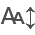

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches

import pandas as pd
import numpy as np

from scipy.stats import pearsonr 
from joblib import Parallel, delayed

# import urllib.request
import fastobo
import json

import goatools
from goatools.obo_parser import GODag

import itables.options as opt
from itables import init_notebook_mode, show
from itables.downsample import as_nbytes, nbytes
from itables.sample_dfs import get_indicators

init_notebook_mode(all_interactive=False)
opt.maxBytes = "128KB"

import seaborn as sns

sns.set()
plt.style.use('default')
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm

import matplotlib.cm as cm
import matplotlib.colors as mcolors

from collections import Counter

import glob
import inspect

import igraph as ig
from community import community_louvain as com
import random

import os


## Funciones que utilizo

In [3]:
# Funciones para abrir archivos:

def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    return data

def abrir_esenciales(nombre_archivo):
    archivo = open(nombre_archivo)
    data = []
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    data = data[2:]
    esenciales = []
    for linea in data:
      if len(linea)>2:
        esenciales.append(linea[1])
    return(esenciales)

In [3]:
# Funciones para graficar

def plot_grafo(grafo):
	pos_layout = nx.spring_layout(grafo, seed = 42)  # Layout para la posición de los nodos
	edges = grafo.edges(data=True)

	fig, axes = plt.subplots(1, 1, figsize = (10,10))

	for i, ax in enumerate(fig.axes):
		edge_colors = nx.get_edge_attributes(grafo, 'color').values()
		ax.set_facecolor('#141414') 
		nx.draw_networkx_nodes(grafo,
							pos = pos_layout,
							node_color = '#cc5c14',
							ax = ax,
							node_size = 2, alpha = 0.4)
		
		nx.draw_networkx_edges(grafo, pos = pos_layout, ax = ax, alpha = .7, edge_color = edge_colors, width = 0.3)

In [4]:
#Colores para enlaces
def assign_edge_colors(G):
    edge_colors = {2: 'plum',
        -2: 'lightseagreen'}

    nx.set_edge_attributes(G, {e: edge_colors.get(G[e[0]][e[1]]['weight'], 'black') for e in G.edges()}, 'color')

def asignar_color(peso, colores_tuple):
	if peso == 1:
		return colores_tuple[0]
	elif peso == 2:
		return colores_tuple[1]
	elif peso == 0.5:
		return colores_tuple[2]
	else:
		return 'gray'  # Opcional, para pesos no especificados
	
def asignar_colores_full(peso, colores_tuple):
	if peso == 1:
		return colores_tuple[0]
	elif peso == 2:
		return colores_tuple[1]
	elif peso == 0.5:
		return colores_tuple[2]
	elif peso == 0.3:
		return colores_tuple[3]
	elif peso == 0.1:
		return colores_tuple[4]
	else:
		return 'gray'  # Opcional, para pesos no especificados
	
def edge_colors_funcion(red_pesada, colores_tuple = ('white', 'plum', 'lightseagreen')):
    # Obtener pesos de los enlaces
	pesos = [data['weight'] for _, _, data in red_pesada.edges(data=True)]

	# Asignar colores basados en los pesos
	if len(colores_tuple) == 3:
		colores = [asignar_color(p, colores_tuple) for p in pesos]
	else:
		colores = [asignar_colores_full(p, colores_tuple) for p in pesos]

	return colores

In [5]:
# Funciones para análisis de redes

def aplicar_louivan(red, resolucion = 1):# Louivan
	com_lv = com.best_partition(red, weight='weight', resolution = resolucion)

	print(f'La cantidad de comunas que maximiza la modularidad es: {max(com_lv.values()) + 1}')
	print(f'La modularidad de dicha partición es: {com.modularity(com_lv, red)}')

	return com_lv

def guardar_louivan(red, path, resolucion = 1):
	partition = aplicar_louivan(red, resolucion = resolucion)

	comunidades = {}
	for nodo, comunidad in partition.items():
		if comunidad not in comunidades:
			comunidades[comunidad] = []
		comunidades[comunidad].append(nodo)

	subgrafos = {}
	for comunidad, nodos in comunidades.items():
		subgrafo = red.subgraph(nodos).copy()
		subgrafos[comunidad] = subgrafo

		ruta = path+f"subgrafo_comunidad_{comunidad}.graphml"
		if not os.path.exists(path):
			os.makedirs(path)

		nx.write_graphml(subgrafo, ruta)

In [156]:
def gigante(G):
	componentes = nx.connected_components(G)
	componentes = list(componentes)
	componentes.sort(key=len, reverse=True)
	componente_gigante = G.subgraph(componentes[0])
	return componente_gigante

def armar_componente_gigante(Red):
  Conjunto_nodos_en_gigante = max(nx.connected_components(Red), key=len)
  Componente_Gigante = Red.subgraph(Conjunto_nodos_en_gigante).copy()
  return Componente_Gigante

def elementos_tabla(Red):
	# Me quedo solo con la componente gigante
	Red_gigante = armar_componente_gigante(Red)

	nodos = Red_gigante.number_of_nodes()
	enlaces = Red_gigante.number_of_edges()
	promedio_grados = np.mean([grado for (nodo,grado) in list(Red_gigante.degree())])
	clustering = nx.average_clustering(Red_gigante)
	
	return (nodos,enlaces,promedio_grados,clustering)

In [151]:
def centralidad_nodos(Red):
    
	diccionario_grado = dict(Red.degree())
	diccionario_cercania = nx.closeness_centrality(Red, u=None, distance='weight', wf_improved=True)
	diccionario_betweenness = nx.betweenness_centrality(Red, weight='weight')
	diccionario_autovalor = nx.eigenvector_centrality(Red, max_iter=5000, tol=1e-06, nstart=None, weight='weight')
	
	return diccionario_grado, diccionario_cercania, diccionario_betweenness, diccionario_autovalor

def armar_tabla_centralidad(Red):

	diccionario_grado, diccionario_cercania, diccionario_betweenness, diccionario_autovalor = centralidad_nodos(Red)

	tabla = pd.DataFrame(columns = ['Nodo', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor'])
	for nodo in Red.nodes():
		df = pd.DataFrame({'Nodo' : nodo, 'Grado' : diccionario_grado[nodo], 'Cercanía' : diccionario_cercania[nodo], 
						   'Betweenness' : diccionario_betweenness[nodo], 'Autovalor' : diccionario_autovalor[nodo]}, index=[0])
		tabla = pd.concat([tabla, df])
	tabla = tabla.reset_index(drop=True)
	return tabla

def porcentaje_mayor_valores(tabla, centralidad, porcentaje):
	tabla_ordenada = tabla.sort_values(by = [centralidad], ascending = False)
	
	tabla_ordenada = tabla_ordenada.reset_index(drop=True)
	cantidad = int(len(tabla_ordenada)*porcentaje)

	return tabla_ordenada[['Nodo', centralidad]][:cantidad]

def porcentaje_mayor_valores_javi(tabla, centralidad, porcentaje):
	tabla_ordenada = tabla.sort_values(by = [centralidad], ascending = False)
	numeros_ordenados = tabla_ordenada[centralidad]
	valor_cota = max(numeros_ordenados) - ((max(numeros_ordenados) - min(numeros_ordenados))*porcentaje)
	# print(valor_cota)
	tt = tabla_ordenada[tabla_ordenada[centralidad] >= valor_cota].copy()
	
	return tt[['Nodo', centralidad]]

def calcular_accuracy(tabla, lista_esenciales, porcentaje, calcular_porcentaje = 'standard'):
	keys = ['Grado', 'Cercanía', 'Betweenness', 'Autovalor']
	accuracy = {keys[0]:[], keys[1]:[], keys[2]:[], keys[3]:[]}

	for centralidad in keys:
		
		if calcular_porcentaje == 'standard':
			tabla_porcentaje = porcentaje_mayor_valores(tabla, centralidad, porcentaje)
		elif calcular_porcentaje == 'javi':
			tabla_porcentaje = porcentaje_mayor_valores_javi(tabla, centralidad, porcentaje)

		nodos_en_tabla = set(tabla_porcentaje['Nodo'])
		esenciales_en_tabla = [nodo for nodo in nodos_en_tabla if nodo in lista_esenciales]

		cantidad_escenciales = len(lista_esenciales)
	
		exactitud = len(esenciales_en_tabla)/cantidad_escenciales * 100
		accuracy[centralidad] = exactitud
		
	return accuracy

In [4]:
Data_esenciales = abrir_txt('../TP3/TC03_data/Essential_ORFs_paperHe.txt')
# print(Data_esenciales)

lista_esenciales = abrir_esenciales('../TP3/TC03_data/Essential_ORFs_paperHe.txt')
# print (lista_esenciales)

## Con redes distintas

In [157]:
def funcion_analisis(archivo, path, resolucion = 1, porcentaje = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], metodo_porcentaje = 'standard', comp_gigante = False):

	if comp_gigante == False:
		red_pesada = nx.read_gpickle(archivo)
		red_evaluar = red_pesada
	elif comp_gigante == True:
		red_pesada = nx.read_gpickle(archivo)
		red_evaluar = gigante(red_pesada)

	guardar_louivan(red_evaluar, path, resolucion=resolucion)

	tabla1 = pd.DataFrame(columns = ['Comunidad', 'Nodos', 'Enlaces', 'Grado promedio', 'Coeficiente de clustering'])
	grafitos = sorted(list(glob.glob(path+'*.graphml')))

	grafitos_ordenados = sorted(grafitos, key=lambda x: int(x.split('_comunidad_')[1].split('.')[0]))

	for grafo in grafitos_ordenados:
		red = nx.read_graphml(grafo)
		nodos, enlaces, promedio_grados, clustering = elementos_tabla(red)
		
		name = grafo.split('_comunidad_')[1].split('.')[0]

		df = pd.DataFrame({'Comunidad' : name, 'Nodos' : nodos, 'Enlaces' : enlaces, 
											'Grado promedio' : promedio_grados, 'Coeficiente de clustering' : clustering}, index=[0])
		tabla1 = pd.concat([tabla1, df])

	tabla1 = tabla1.reset_index(drop=True)

	tabla_centralidades = pd.DataFrame(columns = ['Nodo', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor'])

	for grafo in grafitos_ordenados:
		Red = nx.read_graphml(grafo)
		tabla_aux = armar_tabla_centralidad(Red)
		tabla_centralidades = pd.concat([tabla_centralidades, tabla_aux])
		tabla_centralidades = tabla_centralidades.reset_index(drop=True)

	

	accuracy_df = pd.DataFrame(columns = ['Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor'])

	for porc in porcentaje:
		accuracy = calcular_accuracy(tabla_centralidades, lista_esenciales, porc, calcular_porcentaje = metodo_porcentaje)
		df = pd.DataFrame({'Porcentaje' : str(int(porc*100))+'%', 'Grado' : accuracy['Grado'], 'Cercanía' : accuracy['Cercanía'], 
						'Betweenness' : accuracy['Betweenness'], 'Autovalor' : accuracy['Autovalor']}, index=[0])
		accuracy_df = pd.concat([accuracy_df, df])

	accuracy_df = accuracy_df.reset_index(drop=True)

	return tabla1, tabla_centralidades, accuracy_df

In [35]:
archivo = 'red_pesada-cota06.gpickle'
path = '../../Datos/subgrafos/06entera/'

porcentaje = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

tabla1_06, tabla_centralidades_06, accuracy_df_06 = funcion_analisis(archivo, path, resolucion = 1, porcentaje=porcentaje)

La cantidad de comunas que maximiza la modularidad es: 214
La modularidad de dicha partición es: 0.7892049011642437


In [36]:
archivo = 'red_pesada-cota09+full.gpickle'
path = '../../Datos/subgrafos/09full/'

porcentaje = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

tabla1, tabla_centralidades, accuracy_df = funcion_analisis(archivo, path, resolucion = 1, porcentaje=porcentaje)

La cantidad de comunas que maximiza la modularidad es: 177
La modularidad de dicha partición es: 0.7996312801815353


In [32]:
# Aplico el algoritmo a apms

archivo = 'apms.gpickle'
path = '../../Datos/subgrafos/apms/'

porcentaje = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

tabla1_apms, tabla_centralidades_apms, accuracy_df_apms = funcion_analisis(archivo, path, resolucion = 1, porcentaje=porcentaje)

La cantidad de comunas que maximiza la modularidad es: 211
La modularidad de dicha partición es: 0.7913457805212145


In [37]:
accuracy_df['Categoría'] = '09+full'
accuracy_df_06['Categoría'] = '06entera'
accuracy_df_apms['Categoría'] = 'apms'

df_final = pd.concat([accuracy_df_06, accuracy_df, accuracy_df_apms], ignore_index=True)

df_final = df_final[['Categoría', 'Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor']]
df_final

,Categoría,Porcentaje,Grado,Cercanía,Betweenness,Autovalor
0,06entera,5%,2.33564,2.16263,2.941176,1.470588
1,06entera,10%,7.525952,4.238754,6.747405,2.768166
2,06entera,15%,11.245675,5.968858,10.294118,4.49827
3,06entera,20%,14.792388,8.477509,14.186851,6.6609
4,06entera,25%,19.723183,11.678201,17.387543,9.16955
5,06entera,30%,22.66436,14.359862,20.761246,12.456747
6,06entera,35%,25.605536,16.176471,24.394464,16.522491
7,06entera,40%,29.238754,19.723183,27.422145,20.934256
8,06entera,45%,32.093426,23.010381,30.536332,24.913495
9,06entera,50%,34.515571,26.816609,33.650519,29.152249


Red 06
Red 09+full
Red apms


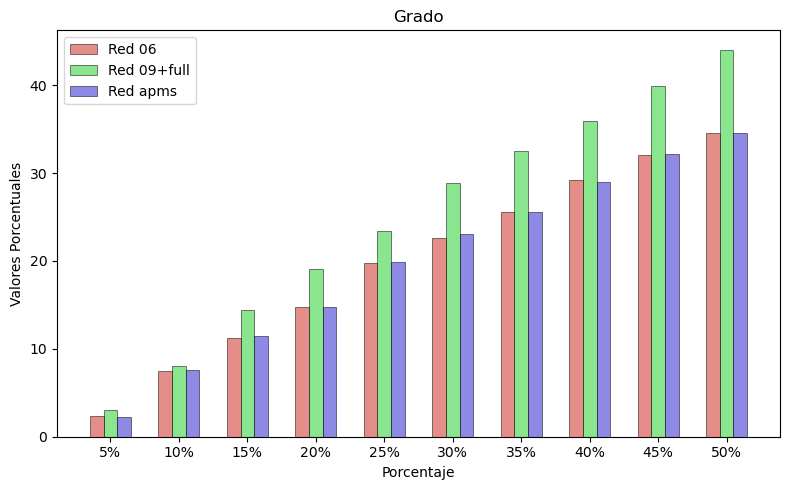

In [89]:
categorias = df_final['Categoría'].unique()
porcentajes = df_final['Porcentaje'].unique()

metricas = ['Grado']

fig, ax = plt.subplots(figsize=(8, 5))

ancho_barra = 0.2 
x_posiciones = np.arange(len(porcentajes)) 


for i, categoria in enumerate(categorias):
	df_categoria = df_final[df_final['Categoría'] == categoria]
	if categoria == '09+full':
		categoria = 'Red 09+full'
	elif categoria == '06entera':
		categoria = 'Red 06'
	elif categoria == 'apms':
		categoria = 'Red apms'
    
	print(categoria)
	for j, metrica in enumerate(metricas):
		ax.bar(x_posiciones + i * ancho_barra + j * ancho_barra / len(metricas),
               df_categoria[metrica],
               width=ancho_barra / len(metricas),
               label=categoria, alpha=0.7, edgecolor='black', linewidth=0.5, color = sns.color_palette('hls')[2*i])#, hatch = 'x')
    
ax.set_xticks(x_posiciones + (len(categorias) - 1) * ancho_barra / 2)
ax.set_xticklabels(porcentajes)
ax.set_xlabel('Porcentaje')
ax.set_ylabel('Valores Porcentuales')
ax.set_title(metrica)
plt.legend(loc='upper left')
plt.tight_layout()


## Pruebo con red cota 0.9 sin apms

In [91]:
cota = 0.9
adyacencia = pd.read_csv('../../Datos/transcriptomas/Matrices_javi/matriz_pearson_breeden_adyacencia-'+str(cota)+'.csv')
adyacencia = adyacencia.set_index('Proteina')

adyacencia_sin_diagonal = adyacencia.copy()
np.fill_diagonal(adyacencia_sin_diagonal.values, 0)
adyacencia_sin_diagonal.head()

,YAL001C,YAL002W,YAL003W,YAL004W,YAL005C,YAL007C,YAL008W,YAL009W,YAL010C,YAL011W,...,YPR194C,YPR195C,YPR196W,YPR197C,YPR198W,YPR199C,YPR200C,YPR201W,YPR202W,YPR203W
Proteina,,,,,,,,,,,,,,,,,,,,,
YAL001C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YAL002W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YAL003W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YAL004W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YAL005C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
def assign_edge_colors(G):
    edge_colors = {2: 'plum',
        -2: 'lightseagreen'}

    nx.set_edge_attributes(G, {e: edge_colors.get(G[e[0]][e[1]]['weight'], 'black') for e in G.edges()}, 'color')

In [93]:
#Le doy a todo
G = nx.from_pandas_adjacency(adyacencia_sin_diagonal)

# Asignar colores a las aristas
assign_edge_colors(G)

In [102]:
G2 = G.copy()

for u, v, data in G2.edges(data=True):
    if data['weight'] == -2.0:
        data['weight'] = 0.5
    elif data['weight'] == 2.0:
        data['weight'] = 1.0

nx.write_gpickle(G2, 'red_pesada-'+str(cota)+'-sinAPMS.gpickle')

In [96]:
G2.number_of_edges(), G2.number_of_nodes()

(14359, 6217)

In [162]:
archivo = 'red_pesada-0.9-sinAPMS.gpickle'
path = '../../Datos/subgrafos/09sinAPMS/'

porcentaje = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, ]

tabla1_09, tabla_centralidades_09, accuracy_df_09 = funcion_analisis(archivo, path, resolucion = 1, porcentaje=porcentaje)

La cantidad de comunas que maximiza la modularidad es: 4124
La modularidad de dicha partición es: 0.8046983209281708


In [124]:
accuracy_df_09

,Porcentaje,Grado,Cercanía,Betweenness,Autovalor
0,5%,6.401384,4.32526,5.276817,5.449827
1,10%,10.467128,8.131488,11.245675,9.861592
2,15%,15.397924,14.186851,15.657439,14.619377
3,20%,20.588235,19.463668,20.847751,17.820069
4,25%,25.346021,24.134948,24.913495,22.491349
5,30%,29.844291,29.757785,29.67128,27.16263
6,35%,35.034602,35.121107,35.034602,32.525952
7,40%,39.359862,39.446367,39.619377,36.33218
8,45%,43.771626,43.944637,44.550173,41.435986
9,50%,48.442907,48.442907,49.221453,45.847751


In [141]:
accuracy_df['Categoría'] = 'Red 09+full'
accuracy_df_06['Categoría'] = 'Red 06'
accuracy_df_apms['Categoría'] = 'Red apms'
accuracy_df_09['Categoría'] = 'Red 09 sinAPMS'

df_final = pd.concat([accuracy_df_06, accuracy_df, accuracy_df_09, accuracy_df_apms], ignore_index=True)

df_final = df_final[['Categoría', 'Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor']]
df_final.head()

,Categoría,Porcentaje,Grado,Cercanía,Betweenness,Autovalor
0,Red 06,5%,2.33564,2.16263,2.941176,1.470588
1,Red 06,10%,7.525952,4.238754,6.747405,2.768166
2,Red 06,15%,11.245675,5.968858,10.294118,4.49827
3,Red 06,20%,14.792388,8.477509,14.186851,6.6609
4,Red 06,25%,19.723183,11.678201,17.387543,9.16955


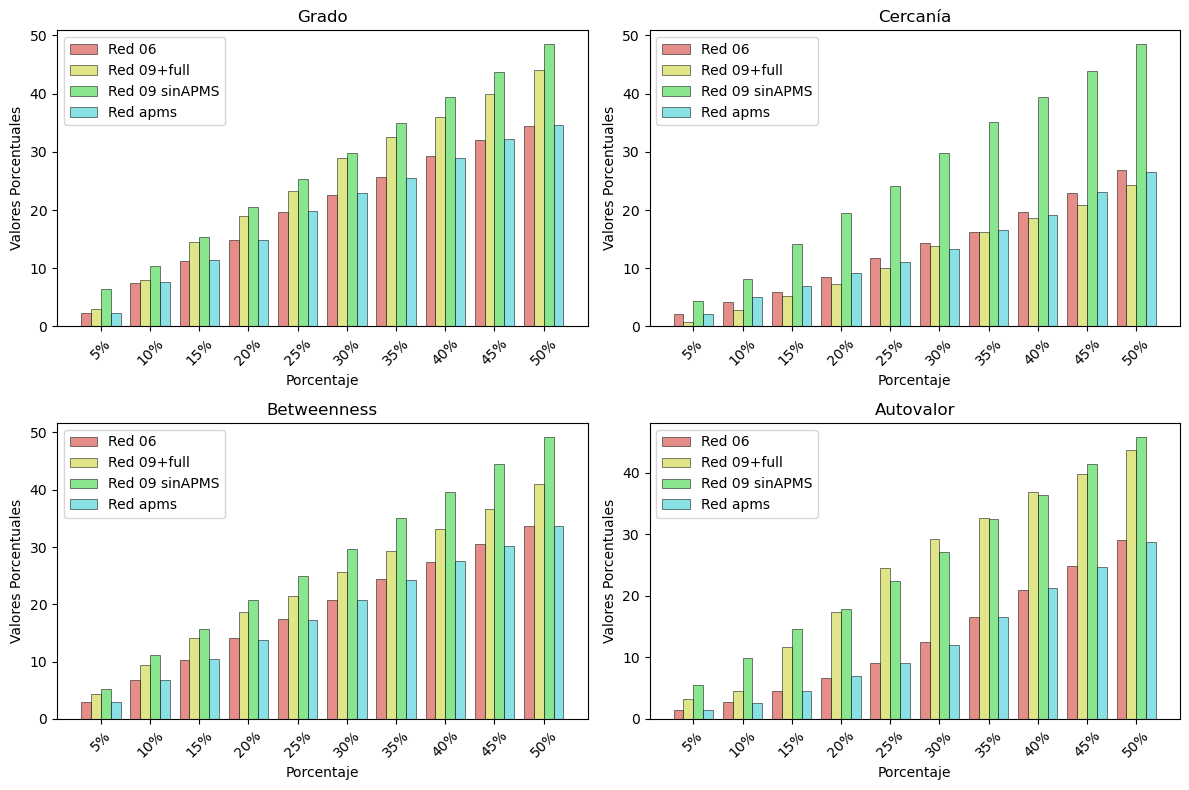

In [132]:
categorias = df_final['Categoría'].unique()
porcentajes = df_final['Porcentaje'].unique()

metricas = ['Grado', 'Cercanía', 'Betweenness', 'Autovalor']

fig, ax = plt.subplots(2, 2, figsize=(12, 8))  # Crear una cuadrícula de subplots 2x2

ancho_barra = 0.2
x_posiciones = np.arange(len(porcentajes))

# Iterar sobre las métricas y categorías
for k, metrica in enumerate(metricas):
    # Calcular la posición del subplot
    fila = k // 2
    columna = k % 2
    eje = ax[fila, columna]
    
    for i, categoria in enumerate(categorias):
        df_categoria = df_final[df_final['Categoría'] == categoria]
        eje.bar(
            x_posiciones + i * ancho_barra,
            df_categoria[metrica],
            width=ancho_barra,
            label=categoria,
            alpha=0.7,
            edgecolor='black',
            linewidth=0.5,
            color=sns.color_palette('hls')[i]
        )
    
    # Configuración específica de cada subplot
    eje.set_xticks(x_posiciones + (len(categorias) - 1) * ancho_barra / 2)
    eje.set_xticklabels(porcentajes, rotation=45)
    eje.set_xlabel('Porcentaje')
    eje.set_ylabel('Valores Porcentuales')
    eje.set_title(metrica)
    eje.legend(loc='upper left')

# Ajustar espaciado entre subplots
plt.tight_layout()

In [165]:
porcentaje = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

lista_archivo = ['red_pesada-cota06.gpickle', 'red_pesada-cota09+full.gpickle', 'red_pesada-0.9-sinAPMS.gpickle', 'apms.gpickle']
lista_path = ['../../Datos/subgrafos/metodoJavi/06entera/', '../../Datos/subgrafos/metodoJavi/09full/', '../../Datos/subgrafos/09sinAPMS/', '../../Datos/subgrafos/apms/']

lista_tabla1, lista_tabla_centralidades, lista_accuracy_df = [], [], []

for i in range(len(lista_archivo)):
	archivo = lista_archivo[i]
	path = lista_path[i]
	tabla1, tabla_centralidades, accuracy_df = funcion_analisis(archivo, path, resolucion = 1, porcentaje=porcentaje, metodo_porcentaje = 'standard')
	lista_tabla1.append(tabla1)
	lista_tabla_centralidades.append(tabla_centralidades)
	lista_accuracy_df.append(accuracy_df)

La cantidad de comunas que maximiza la modularidad es: 213
La modularidad de dicha partición es: 0.789480274979258
La cantidad de comunas que maximiza la modularidad es: 178
La modularidad de dicha partición es: 0.7999851368554031
La cantidad de comunas que maximiza la modularidad es: 4124
La modularidad de dicha partición es: 0.8046802867277314
La cantidad de comunas que maximiza la modularidad es: 213
La modularidad de dicha partición es: 0.7908888724109514


In [ ]:
lista_accuracy_df[0]['Categoría'] = 'Red 06'
lista_accuracy_df[1]['Categoría'] = 'Red 09+full'
lista_accuracy_df[2]['Categoría'] = 'Red 09 sinAPMS'
lista_accuracy_df[3]['Categoría'] = 'Red apms'

df_final = pd.concat([lista_accuracy_df[0], lista_accuracy_df[1], lista_accuracy_df[2], lista_accuracy_df[3]], ignore_index=True)

df_final = df_final[['Categoría', 'Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor']]
df_final.head(15)

,Categoría,Porcentaje,Grado,Cercanía,Betweenness,Autovalor
0,Red 06,5%,2.249135,2.16263,2.941176,1.470588
1,Red 06,10%,7.525952,3.979239,6.6609,2.768166
2,Red 06,15%,11.418685,5.449827,10.121107,4.411765
3,Red 06,20%,15.051903,8.304498,14.273356,6.6609
4,Red 06,25%,19.636678,11.245675,17.387543,9.16955
5,Red 06,30%,22.923875,13.84083,20.761246,12.283737
6,Red 06,35%,25.692042,16.00346,24.134948,16.089965
7,Red 06,40%,28.892734,19.377163,27.249135,20.67474
8,Red 06,45%,32.612457,22.577855,30.276817,24.567474
9,Red 06,50%,34.688581,26.643599,33.391003,28.806228


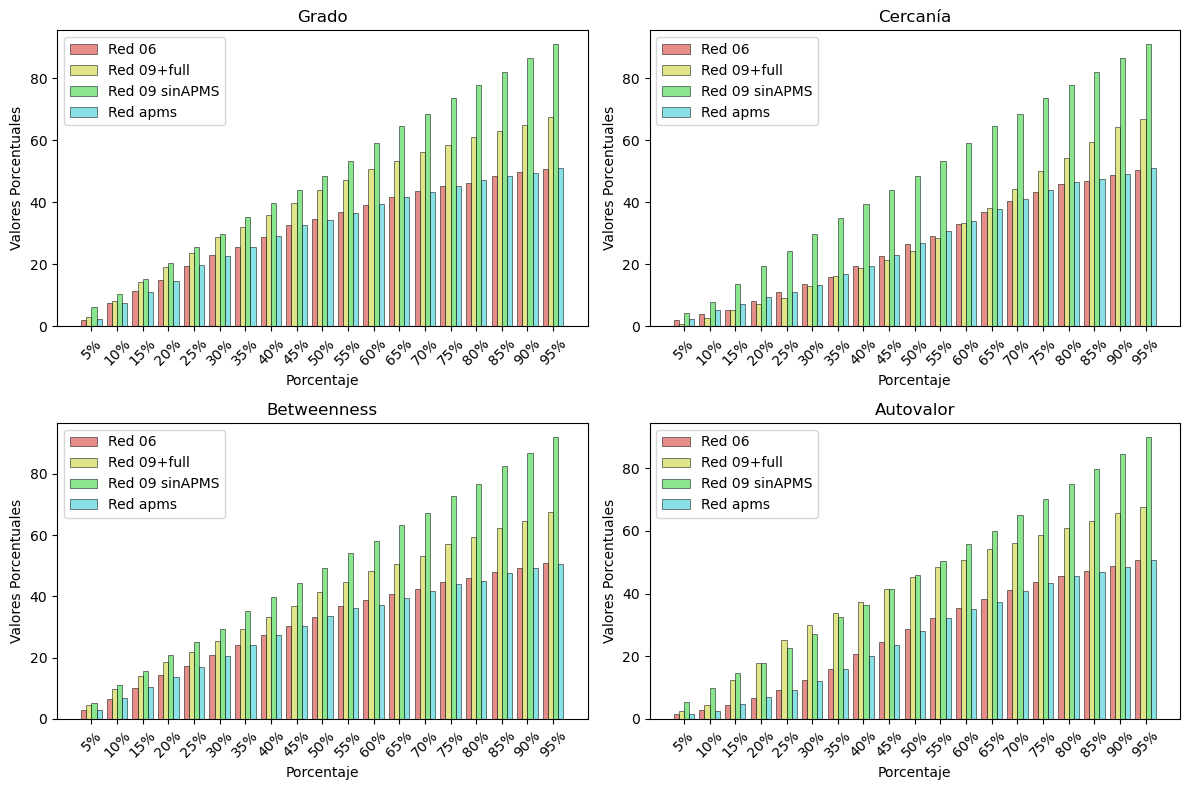

In [169]:
categorias = df_final['Categoría'].unique()
porcentajes = df_final['Porcentaje'].unique()

metricas = ['Grado', 'Cercanía', 'Betweenness', 'Autovalor']

fig, ax = plt.subplots(2, 2, figsize=(12, 8))  # Crear una cuadrícula de subplots 2x2

ancho_barra = 0.2
x_posiciones = np.arange(len(porcentajes))

# Iterar sobre las métricas y categorías
for k, metrica in enumerate(metricas):
    # Calcular la posición del subplot
    fila = k // 2
    columna = k % 2
    eje = ax[fila, columna]
    
    for i, categoria in enumerate(categorias):
        # print(i, categoria)
        df_categoria = df_final[df_final['Categoría'] == categoria]
        eje.bar(
            x_posiciones + i * ancho_barra,
            df_categoria[metrica],
            width=ancho_barra,
            label=categoria,
            alpha=0.7,
            edgecolor='black',
            linewidth=0.5,
            color=sns.color_palette('hls')[i]
        )
    
    # Configuración específica de cada subplot
    eje.set_xticks(x_posiciones + (len(categorias) - 1) * ancho_barra / 2)
    eje.set_xticklabels(porcentajes, rotation=45)
    eje.set_xlabel('Porcentaje')
    eje.set_ylabel('Valores Porcentuales')
    eje.set_title(metrica)
    eje.legend(loc='upper left')

# Ajustar espaciado entre subplots
plt.tight_layout()

## Pruebo calculo de accuracy "Javi"

Ok

La cantidad de comunas que maximiza la modularidad es: 213
La modularidad de dicha partición es: 0.7897073802802909
La cantidad de comunas que maximiza la modularidad es: 178
La modularidad de dicha partición es: 0.7997658181503899
La cantidad de comunas que maximiza la modularidad es: 4126
La modularidad de dicha partición es: 0.8039380207591702
La cantidad de comunas que maximiza la modularidad es: 211
La modularidad de dicha partición es: 0.7913577418801898


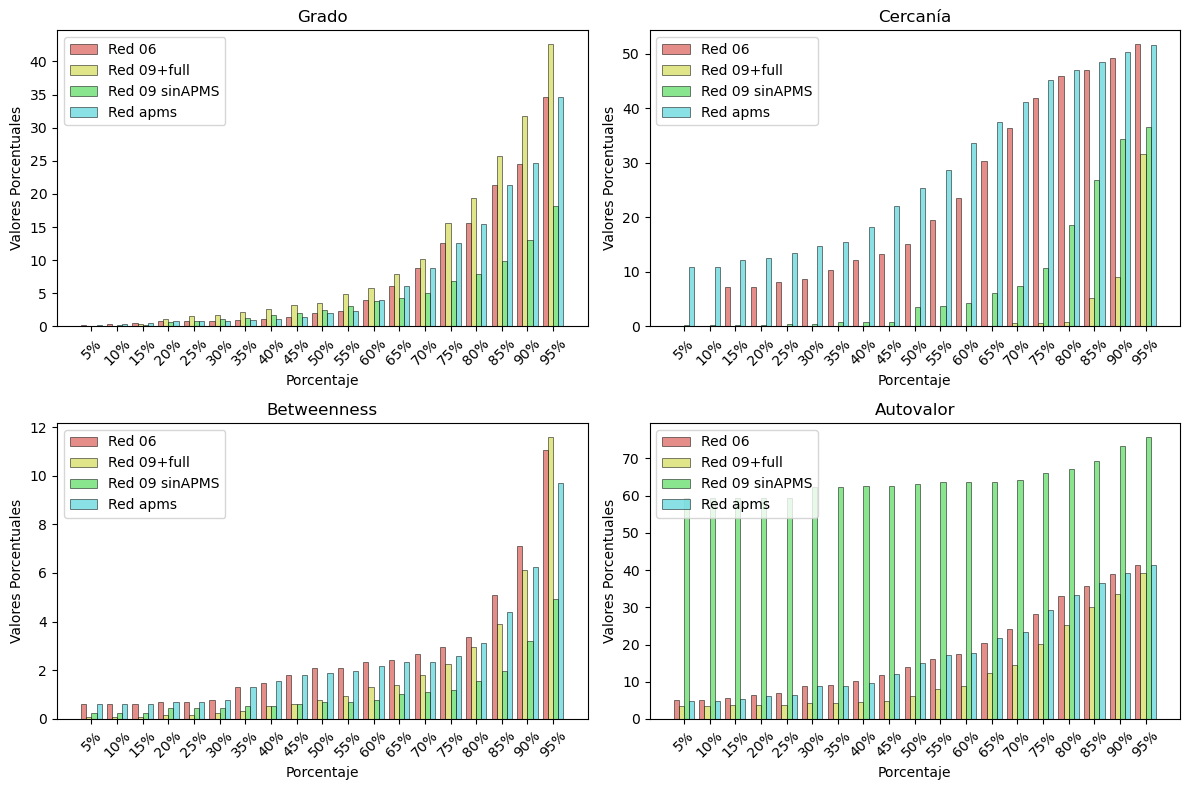

In [170]:
porcentaje = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

lista_archivo = ['red_pesada-cota06.gpickle', 'red_pesada-cota09+full.gpickle', 'red_pesada-0.9-sinAPMS.gpickle', 'apms.gpickle']
lista_path = ['../../Datos/subgrafos/metodoJavi/06entera/', '../../Datos/subgrafos/metodoJavi/09full/', '../../Datos/subgrafos/09sinAPMS/', '../../Datos/subgrafos/apms/']

lista_tabla1, lista_tabla_centralidades, lista_accuracy_df = [], [], []

for i in range(len(lista_archivo)):
	archivo = lista_archivo[i]
	path = lista_path[i]
	tabla1, tabla_centralidades, accuracy_df = funcion_analisis(archivo, path, resolucion = 1, porcentaje=porcentaje, metodo_porcentaje = 'javi')
	lista_tabla1.append(tabla1)
	lista_tabla_centralidades.append(tabla_centralidades)
	lista_accuracy_df.append(accuracy_df)

lista_accuracy_df[0]['Categoría'] = 'Red 06'
lista_accuracy_df[1]['Categoría'] = 'Red 09+full'
lista_accuracy_df[2]['Categoría'] = 'Red 09 sinAPMS'
lista_accuracy_df[3]['Categoría'] = 'Red apms'

df_final = pd.concat([lista_accuracy_df[0], lista_accuracy_df[1], lista_accuracy_df[2], lista_accuracy_df[3]], ignore_index=True)

df_final = df_final[['Categoría', 'Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor']]

categorias = df_final['Categoría'].unique()
porcentajes = df_final['Porcentaje'].unique()

metricas = ['Grado', 'Cercanía', 'Betweenness', 'Autovalor']

fig, ax = plt.subplots(2, 2, figsize=(12, 8))  # Crear una cuadrícula de subplots 2x2

ancho_barra = 0.2
x_posiciones = np.arange(len(porcentajes))

# Iterar sobre las métricas y categorías
for k, metrica in enumerate(metricas):
    # Calcular la posición del subplot
    fila = k // 2
    columna = k % 2
    eje = ax[fila, columna]
    
    for i, categoria in enumerate(categorias):
        # print(i, categoria)
        df_categoria = df_final[df_final['Categoría'] == categoria]
        eje.bar(
            x_posiciones + i * ancho_barra,
            df_categoria[metrica],
            width=ancho_barra,
            label=categoria,
            alpha=0.7,
            edgecolor='black',
            linewidth=0.5,
            color=sns.color_palette('hls')[i]
        )
    
    # Configuración específica de cada subplot
    eje.set_xticks(x_posiciones + (len(categorias) - 1) * ancho_barra / 2)
    eje.set_xticklabels(porcentajes, rotation=45)
    eje.set_xlabel('Porcentaje')
    eje.set_ylabel('Valores Porcentuales')
    eje.set_title(metrica)
    eje.legend(loc='upper left')

# Ajustar espaciado entre subplots
plt.tight_layout()

## Pruebo solo con componentes gigantes de cada red

In [ ]:
porcentaje = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

lista_archivo = ['red_pesada-cota06.gpickle', 'red_pesada-cota09+full.gpickle', 'red_pesada-0.9-sinAPMS.gpickle', 'apms.gpickle']
lista_path = ['../../Datos/subgrafos/metodoJavi/06entera/', '../../Datos/subgrafos/metodoJavi/09full/', '../../Datos/subgrafos/09sinAPMS/', '../../Datos/subgrafos/apms/']

lista_tabla1, lista_tabla_centralidades, lista_accuracy_df = [], [], []

for i in range(len(lista_archivo)):
	print('Analizando archivo: ', lista_archivo[i][:-8])
	archivo = lista_archivo[i]
	path = lista_path[i]
	tabla1, tabla_centralidades, accuracy_df = funcion_analisis(archivo, path, resolucion = 1, porcentaje=porcentaje, metodo_porcentaje = 'standard', comp_gigante = True)
	lista_tabla1.append(tabla1)
	lista_tabla_centralidades.append(tabla_centralidades)
	lista_accuracy_df.append(accuracy_df)

La cantidad de comunas que maximiza la modularidad es: 25
La modularidad de dicha partición es: 0.7596812030272747
La cantidad de comunas que maximiza la modularidad es: 39
La modularidad de dicha partición es: 0.7946732857679478
La cantidad de comunas que maximiza la modularidad es: 23
La modularidad de dicha partición es: 0.7712839896903211
La cantidad de comunas que maximiza la modularidad es: 21
La modularidad de dicha partición es: 0.7609263699881865


In [159]:
lista_accuracy_df[0]['Categoría'] = 'Red 06'
lista_accuracy_df[1]['Categoría'] = 'Red 09+full'
lista_accuracy_df[2]['Categoría'] = 'Red 09 sinAPMS'
lista_accuracy_df[3]['Categoría'] = 'Red apms'

df_final = pd.concat([lista_accuracy_df[0], lista_accuracy_df[1], lista_accuracy_df[2], lista_accuracy_df[3]], ignore_index=True)

df_final = df_final[['Categoría', 'Porcentaje', 'Grado', 'Cercanía', 'Betweenness', 'Autovalor']]
df_final.head(15)

,Categoría,Porcentaje,Grado,Cercanía,Betweenness,Autovalor
0,Red 06,5%,2.681661,2.249135,3.200692,1.730104
1,Red 06,10%,7.612457,3.979239,6.574394,2.854671
2,Red 06,15%,10.207612,6.055363,10.294118,5.103806
3,Red 06,20%,12.802768,8.391003,13.84083,8.044983
4,Red 06,25%,16.868512,11.245675,16.608997,10.121107
5,Red 06,30%,20.761246,12.716263,19.809689,13.84083
6,Red 06,35%,23.010381,15.138408,22.923875,17.733564
7,Red 06,40%,26.124567,18.598616,25.778547,20.761246
8,Red 06,45%,29.584775,22.058824,28.546713,23.961938
9,Red 06,50%,32.439446,25.778547,31.228374,27.422145


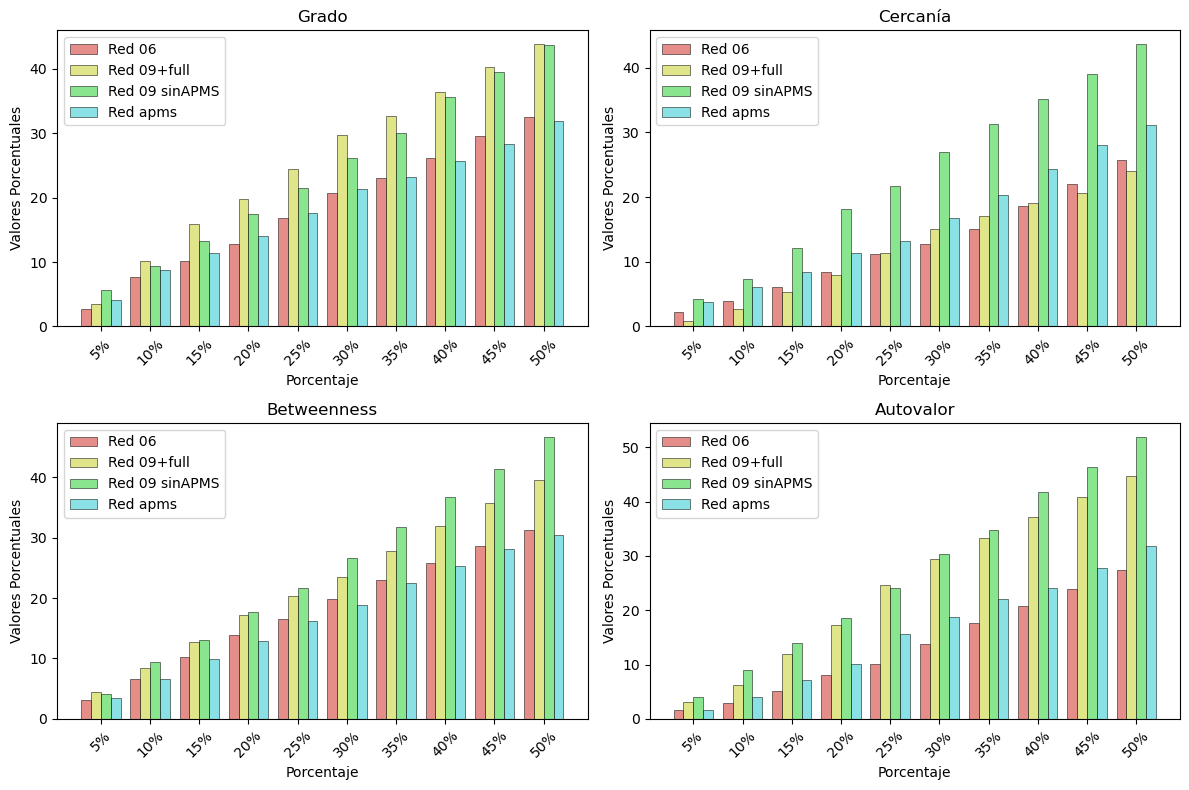

In [160]:
categorias = df_final['Categoría'].unique()
porcentajes = df_final['Porcentaje'].unique()

metricas = ['Grado', 'Cercanía', 'Betweenness', 'Autovalor']

fig, ax = plt.subplots(2, 2, figsize=(12, 8))  # Crear una cuadrícula de subplots 2x2

ancho_barra = 0.2
x_posiciones = np.arange(len(porcentajes))

# Iterar sobre las métricas y categorías
for k, metrica in enumerate(metricas):
    # Calcular la posición del subplot
    fila = k // 2
    columna = k % 2
    eje = ax[fila, columna]
    
    for i, categoria in enumerate(categorias):
        # print(i, categoria)
        df_categoria = df_final[df_final['Categoría'] == categoria]
        eje.bar(
            x_posiciones + i * ancho_barra,
            df_categoria[metrica],
            width=ancho_barra,
            label=categoria,
            alpha=0.7,
            edgecolor='black',
            linewidth=0.5,
            color=sns.color_palette('hls')[i]
        )
    
    # Configuración específica de cada subplot
    eje.set_xticks(x_posiciones + (len(categorias) - 1) * ancho_barra / 2)
    eje.set_xticklabels(porcentajes, rotation=45)
    eje.set_xlabel('Porcentaje')
    eje.set_ylabel('Valores Porcentuales')
    eje.set_title(metrica)
    eje.legend(loc='upper left')

# Ajustar espaciado entre subplots
plt.tight_layout()